<a href="https://colab.research.google.com/github/stanimman/Simple/blob/master/Dog_Breed_Dataset_With_Plot_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5b602000 @  0x7fbb38a372a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
0.4.0
True


In [2]:
!pip uninstall Pillow -y

!pip install Pillow

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


In [1]:
import PIL
print(PIL.PILLOW_VERSION)
import sys

5.3.0


In [2]:
!pip install kaggle-cli
!kg download -u 'stanimman' -p 'Legspinner@1' -c 'dog-breed-identification'

    100% |████████████████████████████████| 81kB 2.9MB/s 
    100% |████████████████████████████████| 5.3MB 5.2MB/s 
    100% |████████████████████████████████| 112kB 26.1MB/s 
    100% |████████████████████████████████| 92kB 25.5MB/s 
    100% |████████████████████████████████| 51kB 19.7MB/s 
  Running setup.py bdist_wheel for kaggle-cli ... - done
  Stored in directory: /root/.cache/pip/wheels/d5/bb/10/c1dd1b08c7433c943cb55c46367ae3f891415e8a37300ff8a7
  Running setup.py bdist_wheel for cliff ... - \ done
  Stored in directory: /root/.cache/pip/wheels/02/22/09/66f8c243f9c68dee7e6456a0fd6c117439a64394fdaf02d965
  Running setup.py bdist_wheel for configparser ... - done
  Stored in directory: /root/.cache/pip/wheels/a3/61/79/424ef897a2f3b14684a7de5d89e8600b460b89663e6ce9d17c
  Running setup.py bdist_wheel for PrettyTable ... - done
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Running setup.py bdist_wheel for pype

In [1]:
!ls

sample_data


In [0]:
!unzip -q labels.csv.zip
!unzip -q train.zip

In [4]:
!unzip sample_submission.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [0]:
#%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [6]:
INPUT_SIZE = 224
NUM_CLASSES = 120
data_dir = '/content'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
#print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222


In [20]:
labels.groupby('breed').rank().head(5)

,id
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [22]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8) # Not clear how it sample equal prob nut I could see they are sampled with equal value for each class 
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape) # The shape is 121 because 120 class + Id (Column)

(8178, 121) (2044, 121)


In [14]:
valid.head()

breed,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
5,002211c81b498ef88e1b40b9abf84e1d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00290d3e1fdd27226ba27a8ce248ce85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,00693b8bc2470375cc744a6391d397ec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,007ff9a78eba2aebb558afea3a51c469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,00a862390341c5be090dd72bd2bc19ef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:


# class_element = np.bincount(classes) # Useful to get value count

In [89]:
img_names[0:9]

['/content/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/train/007b5a16db9d9ff9d7ad39982703e429.jpg',
 '/content/train/007b8a07882822475a4ce6581e70b1f8.jpg',
 '/content/train/0097c6242c6f3071762d9f85c3ef1b2f.jpg',
 '/content/train/00a862390341c5be090dd72bd2bc19ef.jpg',
 '/content/train/00cc68a50b2d016a6b29af628ea4e04b.jpg']

In [0]:
probs = predictions["log_pred"][:,1]
preds = np.argmax(predictions["log_pred"], axis=1)
val_y = np.array(predictions["val_y"])
img_names = predictions["img_names"]
classes = predictions["classes"]

In [0]:
df = pd.DataFrame(valid.groupby('id').idxmax(axis=1).reset_index()) # group by is just a cheater bcoz all id is unique , after group by we taking the  ".idxmax() - e Return index of first occurrence of maximum over requested axis. NA/null values are excluded."
classes = list(df.iloc[:,2])



In [0]:
image_path = list(df.iloc)

In [0]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].as_matrix().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [0]:
TRAIN_IMG_PATH = "/content/train"
#TEST_IMG_PATH = "/content/test"
LABELS_CSV_PATH = "/content/labels.csv"
SAMPLE_SUB_PATH = "/content/sample_submission.csv"

In [30]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Scale(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, TRAIN_IMG_PATH, transform=ds_trans)
valid_ds = DogsDataset(valid, TRAIN_IMG_PATH, transform=ds_trans)


train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=8, shuffle=True, num_workers=4)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [47]:
valid_ds[0]

[tensor([[[-0.2513, -0.5938, -0.5938,  ...,  1.8893,  1.7009,  1.4954],
          [-0.1828, -0.4397, -0.4568,  ...,  1.7352,  1.6324,  1.2899],
          [ 0.4166, -0.0287, -0.4397,  ...,  1.3755,  1.5639,  1.5982],
          ...,
          [-0.4568, -0.2684, -0.0629,  ..., -0.3027,  0.0569,  0.1768],
          [-0.0629,  0.0056,  0.0569,  ..., -0.0972,  0.1597,  0.1083],
          [ 0.1083,  0.1426,  0.0912,  ...,  0.1426,  0.3652,  0.2453]],
 
         [[-0.4951, -0.6352, -0.6001,  ...,  1.6933,  1.2206,  0.8004],
          [-0.5476, -0.4251, -0.3901,  ...,  1.4832,  1.0630,  0.4503],
          [-0.2500, -0.0574, -0.3200,  ...,  1.0105,  0.8880,  0.6078],
          ...,
          [-1.1954, -1.2304, -1.0903,  ..., -1.1253, -0.6702, -0.4776],
          [-0.8803, -0.8803, -0.8452,  ..., -0.8978, -0.5651, -0.5651],
          [-0.7752, -0.6527, -0.6877,  ..., -0.6176, -0.3550, -0.4426]],
 
         [[-1.3339, -0.7936, -0.6367,  ...,  1.2282,  0.5485, -0.1138],
          [-1.0027, -0.8458,

In [0]:
dataloaders = {"train": train_dl, "valid": valid_dl}

In [32]:
model = torchvision.models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 45600559.83it/s]


In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
import torch.nn as nn
model.fc = nn.Linear(model.fc.in_features, 120)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.003)

In [0]:
from time import time
import copy
import sys
dataset_sizes = {"train": len(train_ds),"valid":len(valid_ds)}

In [0]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=25):
    since = time()
    model = model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Count training and validation examples
    train_examples = len(dataloaders['train'].dataset)
    valid_examples = len(dataloaders['valid'].dataset)

    train_bs = dataloaders['train'].batch_size
    valid_bs = dataloaders['valid'].batch_size
    
    # Calculate number of minibatches for training and validation
    num_minibatch = {'train': int(np.ceil(train_examples / train_bs)), 
                     'valid': int(np.ceil(valid_examples / valid_bs))}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            mini_batch = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                mini_batch += 1
                # Print status bar
                if phase == 'train':
                    mini_batch_comp = int((mini_batch/num_minibatch[phase])*100)//2
                    sys.stdout.write('\r')
                    sys.stdout.write("%s[%-50s] %d%%" %(phase, "="*mini_batch_comp, 2*mini_batch_comp))
                else:
                    mini_batch_comp = int((mini_batch/num_minibatch[phase])*100)//5
                    sys.stdout.write('\r')
                    sys.stdout.write("%s[%-20s] %d%%" %(phase, "="*mini_batch_comp, 5*mini_batch_comp))

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("")
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [39]:
model = train_model(model, criterion, optimizer, dataloaders, device, num_epochs=3)

Epoch 1/3
----------
train[==================================================] 100%
train Loss: 2.3069823339242577 Acc: 0.46184886280264126
valid[====================] 100%
valid Loss: 1.311290991866192 Acc: 0.6912915851272016

Epoch 2/3
----------
train[==================================================] 100%
train Loss: 1.4260140794228446 Acc: 0.6505258009293227
valid[====================] 100%
valid Loss: 1.342328486198636 Acc: 0.7172211350293541

Epoch 3/3
----------
train[==================================================] 100%
train Loss: 1.3455905583194019 Acc: 0.67816091954023
valid[====================] 100%
valid Loss: 1.2519831349690482 Acc: 0.7524461839530332

Training complete in 6.0m 7.228357553482056s
Best val Acc: 0.7524461839530332


In [0]:
torch.save(model, "dogsBreed_resnet34")

In [0]:
model = torch.load("dogsBreed_resnet34")

In [0]:
valid_dl_no_shuffle = DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=4)

In [0]:
import torch.nn.functional as F
def prediction_fn(model, valid_dl,device):
  since = time()
  model = model.to(device)
  phase ='valid'
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  results = {}
  results["log_pred"] = np.empty((0,120), float)
  mini_batch = 1
  # Count training and validation examples
  #train_examples = len(dataloaders['train'].dataset)
  valid_examples = len(valid_dl.dataset)

  #train_bs = dataloaders['train'].batch_size
  valid_bs = valid_dl.batch_size

  # Calculate number of minibatches for training and validation
  num_minibatch = { #'train': int(np.ceil(train_examples / train_bs)), 
                   'valid': int(np.ceil(valid_examples / valid_bs))}
  
  for inputs, labels in valid_dl:
                inputs = inputs.to(device)
                labels = labels.to(device)

                
                # Print status bar
                if phase == 'train':
                    mini_batch_comp = int((mini_batch/num_minibatch[phase])*100)//2
                    sys.stdout.write('\r')
                    sys.stdout.write("%s[%-50s] %d%%" %(phase, "="*mini_batch_comp, 2*mini_batch_comp))
                else:
                    mini_batch_comp = int((mini_batch/num_minibatch[phase])*100)//5
                    sys.stdout.write('\r')
                    sys.stdout.write("%s[%-20s] %d%%" %(phase, "="*mini_batch_comp, 5*mini_batch_comp))

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = F.softmax(outputs, 1)
                    outputs = outputs.cpu().data.numpy()
                    results["log_pred"] = np.append(results["log_pred"], outputs, axis = 0)
                    
                mini_batch += 1
  
  time_elapsed = time() - since
  print("")
  print(f'Time taken for prediction {time_elapsed // 60}m {time_elapsed % 60}s')

  return results

In [120]:
predictions = prediction_fn(model,valid_dl_no_shuffle,device)

valid[====================] 100%
Time taken for prediction 0.0m 22.56799602508545s


In [0]:
# Image Names
Id = list( valid.iloc[:,0])
file_ext = '.jpg'
IMG_PATH = "/content/train/"
img_names = [s + file_ext for s in Id]
img_names = [IMG_PATH + s for s in img_names]

# val_y
mat = valid.iloc[:,1:].as_matrix().astype('float')
val_y = np.argmax(mat, axis=1)

# classses
df = pd.DataFrame(valid.groupby('id').idxmax(axis=1).reset_index()) # group by is just a cheater bcoz all id is unique , after group by we taking the  ".idxmax() - e Return index of first occurrence of maximum over requested axis. NA/null values are excluded."
classes = list(df.iloc[:,2])

# Prob 
probs = [pred['log_pred'][idx][item] for idx,item in enumerate(val_y)]

# Preds_val
preds = np.argmax(predictions["log_pred"], axis=1)


In [143]:
probs[0]

0.8655746579170227

In [0]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

In [0]:
def rand_by_correct(is_correct): 
    return rand_by_mask((preds == val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: 
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(img_names, val_y, idx): 
    return np.array(PIL.Image.open(img_names[idx]))

In [0]:
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(img_names, val_y, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    #title_names = [classes[x] for x in idxs]
    #title_concat = [m+str(n) for m,n in zip(title_names , title_probs)]
    print(title)
    if len(imgs) > 0:
        return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))
    else:
        print('Not Found.')

Correctly classified


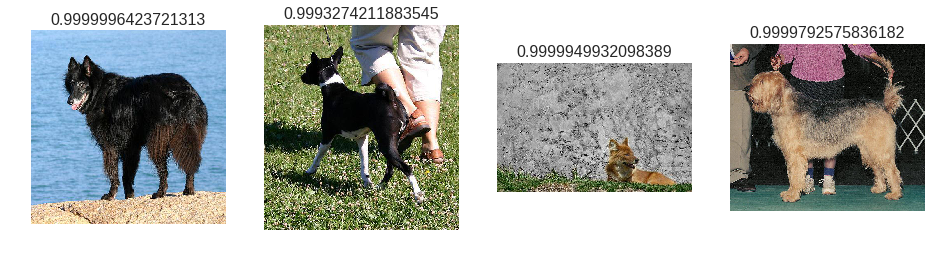

In [139]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


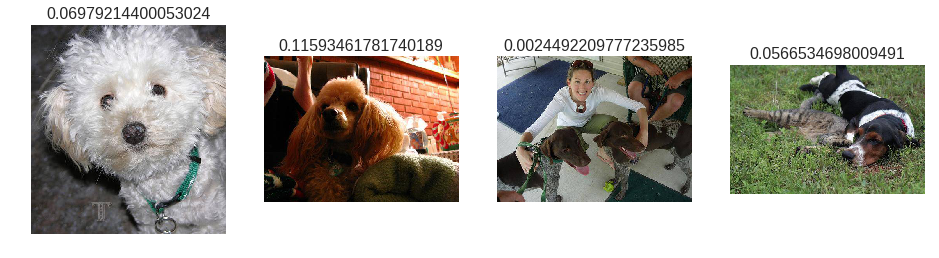

In [140]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
        return idxs[np.argsort(mult * [probs[x] for x in idxs])[:4]]

def most_by_correct(y, is_correct): 
    if (y==1) == is_correct:
        mult = -1
    else:
        mult = 1
    return most_by_mask(((preds == val_y)==is_correct) & (val_y == y), mult)

Most correct irish_water_spaniel


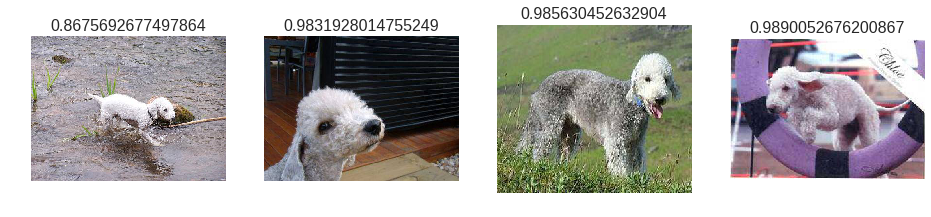

In [195]:
plot_val_with_title(most_by_correct(10, True), "Most correct "+classes[10])

Most incorrect golden_retriever


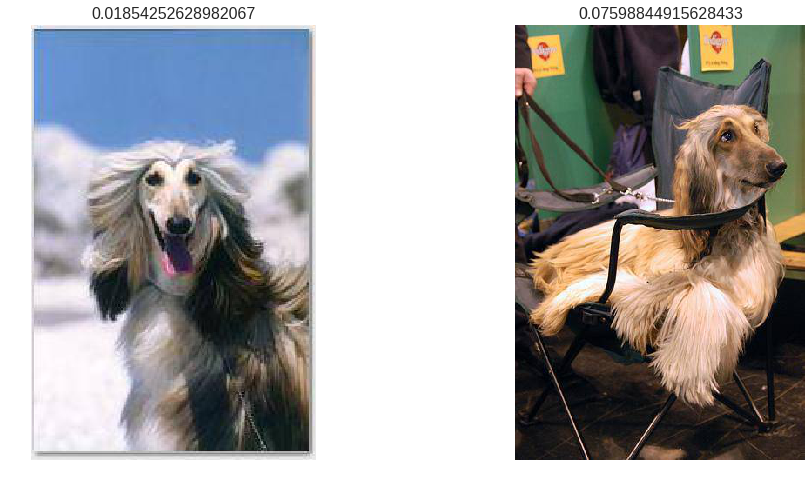

In [200]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect "+classes[1])

In [0]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4] # need to check why probs is not working need to change it accordingly
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## LR Finder

In [0]:
class lr_finder():
    
    """Implementation of LR Find function explained in the paper:
        https://arxiv.org/abs/1506.01186
        Tries a range of Learning Rates and returns the loss for
        the entire range.
        
        Args:
            model: Network for which the LR has to be found
            criterion: Loss function
            optimizer: pytorch optimizer
                Optimizer can have different param_groups for
                    different layers of the network to have 
                    different LRs. The layers should be in order
                    of closeness to the input. i.e. the layer 
                    closest to the input should be the first and
                    the last layer before the loss function should
                    be the last
            dataloaders: Dictionary containing DataLoader for "train"
            device: "CPU" or "CUDA"
            factor: Factor by which the LR has to be reduced for the
                earlier groups. For e.g. if the factor is 10, then if 
                the last group has a LR of 0.2, the group ahead of it 
                will have a LR of 0.02 and the one ahead of the second
                group will have an LR of 0.002 and so on.
    """
    
    def __init__(self, model, criterion, optimizer, dataloaders, device, factor=10):
        
        model = model.to(device)
        self.model = model.train()
        self.criterion = criterion
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.device = device
        self.results = None
        self.factor = factor
        
    def fit(self):
        
        # Count number of examples in train dataset
        train_examples = len(self.dataloaders['train'].dataset)
        train_bs = self.dataloaders['train'].batch_size
        # Count number of mini batches
        mini_batches = train_examples // train_bs
        increment = 16 / mini_batches
        
        # Start with a very low LR for the last layer
        lr_hist = []
        # Save loss history of the last layer
        loss_hist = []
        cur_lr = 1e-1
        
        mini_batch = 0
        for inputs, labels in self.dataloaders['train']:
            
            # Print status bar
            mini_batch_comp = int((mini_batch/mini_batches)*100)//2
            sys.stdout.write('\r')
            sys.stdout.write("[%-50s] %d%%" %("="*mini_batch_comp, 2*mini_batch_comp))
            mini_batch += 1
            
            model = self.model
            criterion = self.criterion
            optimizer = self.optimizer
            device = self.device
            
            # Set differential learning rates for various param groups based 
            # on factor value
            fa = 0
            for pg in optimizer.param_groups[::-1]:
                pg['lr'] = cur_lr / (self.factor ** fa)
                fa += 1
            lr_ = []
            for pg in optimizer.param_groups:
                lr_.append(pg['lr'])
            lr_hist.append(lr_)
            optimizer.zero_grad()
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            loss_hist.append(loss.item())
            cur_lr = cur_lr + (lr_hist[-1][-1] * increment)
            
            if cur_lr == 0:
                cur_lr += increment
            
            # Stop iteration at a LR of 1e1
            if cur_lr > 10:
                break
                
            # Stop iteration is loss is getting too high
            if (loss > (5*loss_hist[0])) & (cur_lr > .1):
                break
            
            if (lr_hist[-1][-1] * 10 - cur_lr) < (increment * lr_hist[-1][-1]):
                # Reset when LR is reduced by a factor of 10 
                cur_lr = round(lr_hist[-1][-1]*10, 8)
        
        if len(lr_hist) > len(loss_hist):
            lr_hist.pop(-1)
                
        self.results = {'lr': lr_hist, 'loss': loss_hist}
        self.results['loss'] = self.moving_average()
                     
    def plot_lr(self):
        
        # Plot LR vs Loss
        if self.results:
            lr_ = [i[-1] for i in self.results["lr"]]
            plt.plot(lr_, self.results['loss'])
            plt.xscale("log")
            plt.show()
        else:
            print("Results not available")
            
    def moving_average(self):
        # Smoothen the loss by calculating moving average
        loss_hist = np.cumsum(self.results['loss'])
        loss_hist /= np.arange(1, len(loss_hist)+1)
        return loss_hist
    
    def lr_schedule(self, group = -1):
        # Plot LR schedule
        lr_ = [i[group] for i in self.results["lr"]]
        plt.plot(lr_)

In [0]:
lr_find = lr_finder(model, criterion, optimizer, dataloaders, device)

In [209]:
lr_find.fit()

[==============                                    ] 28%

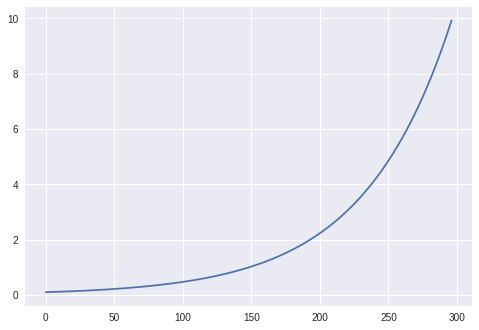

In [210]:
lr_find.lr_schedule()

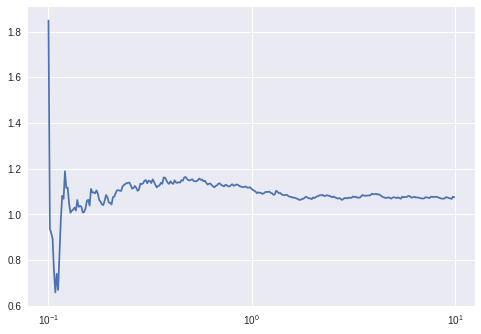

In [211]:
lr_find.plot_lr()

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 120)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized / we have updated all the layer in the resnet architecture by passing model_ft.parameters()
#to the optimizer , again SGD with momentum is preferred over Adam ?? 
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
lr_find = lr_finder(model_ft, criterion, optimizer_ft, dataloaders, device)

In [138]:
lr_find.fit()

[============================                      ] 56%

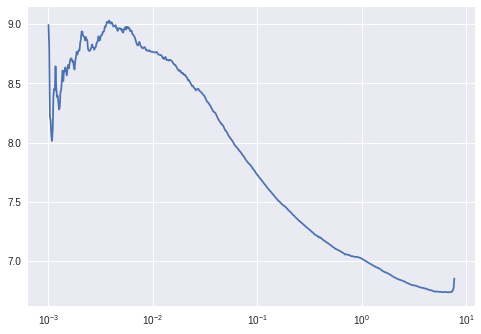

In [139]:
lr_find.plot_lr()

In [0]:
dataset_sizes = {"train": len(train_ds),"val":len(valid_ds)}

In [72]:
print(dataset_sizes)

{'train': 8178, 'val': 2044}


In [143]:
model, lr_hist = train_model(model_ft, criterion, optimizer_ft, dataloaders, device, scheduler, num_epochs=25)

Epoch 1/25
----------
train[==================================================] 100%
train Loss: 1.063960767602769 Acc: 0.6724137931034483
val[====================] 100%
val Loss: 2.808013797972767 Acc: 0.3845401174168297

Epoch 2/25
----------
train[==================================================] 100%
train Loss: 0.7867576776550229 Acc: 0.7578870139398386
val[====================] 100%
val Loss: 2.7865011904337633 Acc: 0.39774951076320936

Epoch 3/25
----------
train[==================================================] 100%
train Loss: 0.5919074528839454 Acc: 0.8165810711665444
val[====================] 100%
val Loss: 3.4135780390461363 Acc: 0.36350293542074363

Epoch 4/25
----------
train[==================================================] 100%
train Loss: 0.4393373880855143 Acc: 0.8630471998043532
val[====================] 100%
val Loss: 3.0258722988826654 Acc: 0.4207436399217221

Epoch 5/25
----------
train[==================================================] 100%
train Loss: 0.3

In [141]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,device,
                       num_epochs=5)

TypeError: ignored

In [144]:
!ls

labels.csv	sample_data	       sample_submission.csv.zip  train
labels.csv.zip	sample_submission.csv  test.zip			  train.zip


In [0]:
# Identifying the layer name in the ResNet is difficult bcoz same name is given for the conv / relu / for each layer , so it is better to find the freeze layer manually and use it as below 
'''def get_count(layer_name,model_name):
  ct  = 0 
  layer_count ={}
  for name, child in model_name.named_children():
      for name2, params in child.named_parameters():
        layer_count[name2] = ct
        ct +=1
  return layer_count[layer_name]

def freeze_till(layer_name,model_name):
  ct  = 0 
  count = get_count(layer_name,model_name)
  
  for name, child in model_name.named_children():
    for name2, params in child.named_parameters():
      
      if ct > count :
          
            params.requires_grad = True
      else :
            params.requires_grad = False
      ct +=1 '''

In [0]:
model_conv = torchvision.models.resnet50(pretrained=True)

ct = 0
for name, child in model_conv.named_children():
    ct += 1
    if ct < 8:
        for name2, params in child.named_parameters():
          params.requires_grad = False       

In [95]:
# To view which layers are freeze and which layers are not freezed:

for name, child in model_conv.named_children():
  print ('name :',name)
  for name_2, params in child.named_parameters():
    print(name_2, params.requires_grad)

name : conv1
weight False
name : bn1
weight False
bias False
name : relu
name : maxpool
name : layer1
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
0.conv3.weight False
0.bn3.weight False
0.bn3.bias False
0.downsample.0.weight False
0.downsample.1.weight False
0.downsample.1.bias False
1.conv1.weight False
1.bn1.weight False
1.bn1.bias False
1.conv2.weight False
1.bn2.weight False
1.bn2.bias False
1.conv3.weight False
1.bn3.weight False
1.bn3.bias False
2.conv1.weight False
2.bn1.weight False
2.bn1.bias False
2.conv2.weight False
2.bn2.weight False
2.bn2.bias False
2.conv3.weight False
2.bn3.weight False
2.bn3.bias False
name : layer2
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
0.conv3.weight False
0.bn3.weight False
0.bn3.bias False
0.downsample.0.weight False
0.downsample.1.weight False
0.downsample.1.bias False
1.conv1.weight False
1.bn1.weight Fa

In [79]:
len(list(filter(lambda p: p.requires_grad, model_conv.parameters())))

32

In [0]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 120)

model_conv = model_conv.to(device)


criterion = nn.CrossEntropyLoss()

#model_conv = freeze_till('transition2.conv.weight',model_conv)

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(list(filter(lambda p: p.requires_grad, model_conv.parameters())), lr=0.001, momentum=0.9)
.

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [81]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 2.3948 Acc: 0.4585
val Loss: 0.7969 Acc: 0.7588

Epoch 1/4
----------
train Loss: 0.9838 Acc: 0.7402
val Loss: 0.6855 Acc: 0.7779

Epoch 2/4
----------
train Loss: 0.6495 Acc: 0.8276
val Loss: 0.6459 Acc: 0.7935

Epoch 3/4
----------
train Loss: 0.4361 Acc: 0.8842
val Loss: 0.6362 Acc: 0.8082

Epoch 4/4
----------
train Loss: 0.2886 Acc: 0.9274
val Loss: 0.6789 Acc: 0.7975

Training complete in 11m 55s
Best val Acc: 0.808219


In [0]:
class lr_finder():
    
    """Implementation of LR Find function explained in the paper:
        https://arxiv.org/abs/1506.01186
        Tries a range of Learning Rates and returns the loss for
        the entire range.
        
        Args:
            model: Network for which the LR has to be found
            criterion: Loss function
            optimizer: pytorch optimizer
                Optimizer can have different param_groups for
                    different layers of the network to have 
                    different LRs. The layers should be in order
                    of closeness to the input. i.e. the layer 
                    closest to the input should be the first and
                    the last layer before the loss function should
                    be the last
            dataloaders: Dictionary containing DataLoader for "train"
            device: "CPU" or "CUDA"
            factor: Factor by which the LR has to be reduced for the
                earlier groups. For e.g. if the factor is 10, then if 
                the last group has a LR of 0.2, the group ahead of it 
                will have a LR of 0.02 and the one ahead of the second
                group will have an LR of 0.002 and so on.
    """
    
    def __init__(self, model, criterion, optimizer, dataloaders, device, factor=10):
        
        model = model.to(device)
        self.model = model.train()
        self.criterion = criterion
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.device = device
        self.results = None
        self.factor = factor
        
    def fit(self):
        
        # Count number of examples in train dataset
        train_examples = len(self.dataloaders['train'].dataset)
        train_bs = self.dataloaders['train'].batch_size
        # Count number of mini batches
        mini_batches = train_examples // train_bs
        increment = 16 / mini_batches
        
        # Start with a very low LR for the last layer
        lr_hist = []
        # Save loss history of the last layer
        loss_hist = []
        cur_lr = 1e-3
        
        mini_batch = 0
        for inputs, labels in self.dataloaders['train']:
            
            # Print status bar
            mini_batch_comp = int((mini_batch/mini_batches)*100)//2
            sys.stdout.write('\r')
            sys.stdout.write("[%-50s] %d%%" %("="*mini_batch_comp, 2*mini_batch_comp))
            mini_batch += 1
            
            model = self.model
            criterion = self.criterion
            optimizer = self.optimizer
            device = self.device
            
            # Set differential learning rates for various param groups based 
            # on factor value
            fa = 0
            for pg in optimizer.param_groups[::-1]:
                pg['lr'] = cur_lr / (self.factor ** fa)
                fa += 1
            lr_ = []
            for pg in optimizer.param_groups:
                lr_.append(pg['lr'])
            lr_hist.append(lr_)
            optimizer.zero_grad()
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            loss_hist.append(loss.item())
            cur_lr = cur_lr + (lr_hist[-1][-1] * increment)
            
            if cur_lr == 0:
                cur_lr += increment
            
            # Stop iteration at a LR of 1e1
            if cur_lr > 10:
                break
                
            # Stop iteration is loss is getting too high
            if (loss > (5*loss_hist[0])) & (cur_lr > .1):
                break
            
            if (lr_hist[-1][-1] * 10 - cur_lr) < (increment * lr_hist[-1][-1]):
                # Reset when LR is reduced by a factor of 10 
                cur_lr = round(lr_hist[-1][-1]*10, 8)
        
        if len(lr_hist) > len(loss_hist):
            lr_hist.pop(-1)
                
        self.results = {'lr': lr_hist, 'loss': loss_hist}
        self.results['loss'] = self.moving_average()
                     
    def plot_lr(self):
        
        # Plot LR vs Loss
        if self.results:
            lr_ = [i[-1] for i in self.results["lr"]]
            plt.plot(lr_, self.results['loss'])
            plt.xscale("log")
            plt.show()
        else:
            print("Results not available")
            
    def moving_average(self):
        # Smoothen the loss by calculating moving average
        loss_hist = np.cumsum(self.results['loss'])
        loss_hist /= np.arange(1, len(loss_hist)+1)
        return loss_hist
    
    def lr_schedule(self, group = -1):
        # Plot LR schedule
        lr_ = [i[group] for i in self.results["lr"]]
        plt.plot(lr_)

In [0]:
lr_find = lr_finder(model_conv, criterion, optimizer_conv, dataloaders, device)

In [116]:
lr_find.fit()

[==============                                    ] 28%

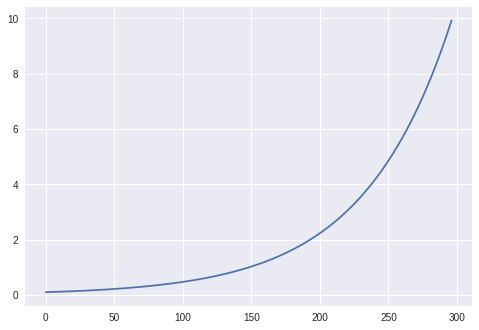

In [117]:
lr_find.lr_schedule()

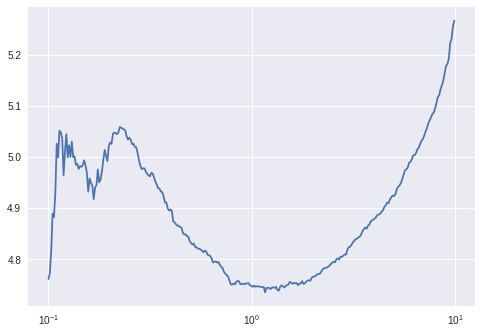

In [118]:
lr_find.plot_lr()

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomRotation(degrees=10, resample=False, expand=False, center=None),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
class _LRScheduler_(object):
    # Modified code from torch.optim.lr_scheduler
    def __init__(self, optimizer, last_batch=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        if last_batch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.step(last_batch + 1)
        self.last_batch = last_batch

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.

        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.

        Arguments:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_lr(self):
        raise NotImplementedError

    def step(self, batch=None):
        if batch is None:
            batch = self.last_batch + 1
        self.last_batch = batch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [0]:
class CosineAnnealingLR_(_LRScheduler_):
    # Modified code from torch.optim.lr_scheduler
    r"""Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:

    .. math::

        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))

    When last_epoch=-1, sets initial lr as lr.

    It has been proposed in
    `SGDR: Stochastic Gradient Descent with Warm Restarts`_. Note that this only
    implements the cosine annealing part of SGDR, and not the restarts.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_max (int): Maximum number of iterations.
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.

    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

    def __init__(self, optimizer, T_max, eta_min=0, last_batch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        super(CosineAnnealingLR_, self).__init__(optimizer, last_batch)

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_batch / self.T_max)) / 2
                for base_lr in self.base_lrs]

In [0]:
class SGDR(CosineAnnealingLR_):
    r"""Implements cosine annealing of LR
    Args:
        iterations: no. of iterations after which LR has to be reset
            in general iterations must be equal to no. of minibatches in 
            a training epoch
        cycle_mult: factor by which the iteration cycle has to be 
            increased after every cycle. Default: 1
    """
    def __init__(self, optimizer, T_max, eta_min = 0, last_batch = -1, cycle_mult = 1):
        self.cycle_mult = cycle_mult
        super(SGDR, self).__init__(optimizer, T_max, eta_min, last_batch)
        
    def step(self, batch=None):
        if batch is None:
            batch = self.last_batch + 1
        self.last_batch = batch
        if ((self.last_batch%self.T_max) == 0) & (self.last_batch != 0):
            # Reset after T_max number of iterations are reached
            self.last_batch = 0
            self.T_max = self.T_max * self.cycle_mult
            # Increase T_max by cycle_mult after each cycle
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [0]:
import os
import sys
import PIL
import math
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
from time import time
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from functools import partial
import torch.nn.functional as F
import matplotlib.pyplot as plt
from bisect import bisect_right
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models, transforms

In [0]:

scheduler = SGDR(optimizer = optimizer_conv, T_max = 360)

In [0]:
def train_model(model, criterion, optimizer, dataloaders, device, scheduler, num_epochs=25):
    lr_hist = []
    since = time()
    model = model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Count training and validation examples
    train_examples = len(dataloaders['train'].dataset)
    valid_examples = len(dataloaders['val'].dataset)

    train_bs = dataloaders['train'].batch_size
    valid_bs = dataloaders['val'].batch_size
    
    # Calculate number of minibatches for training and validation
    num_minibatch = {'train': int(np.ceil(train_examples / train_bs)), 
                     'val': int(np.ceil(valid_examples / valid_bs))}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            mini_batch = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                mini_batch += 1
                # Print status bar
                if phase == 'train':
                    mini_batch_comp = int((mini_batch/num_minibatch[phase])*100)//2
                    sys.stdout.write('\r')
                    sys.stdout.write("%s[%-50s] %d%%" %(phase, "="*mini_batch_comp, 2*mini_batch_comp))
                else:
                    mini_batch_comp = int((mini_batch/num_minibatch[phase])*100)//5
                    sys.stdout.write('\r')
                    sys.stdout.write("%s[%-20s] %d%%" %(phase, "="*mini_batch_comp, 5*mini_batch_comp))

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        lr_ = []
                        for group in optimizer.param_groups:
                            lr_.append(group["lr"])
                        lr_hist.append(lr_)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("")
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, lr_hist

In [0]:
model = torchvision.models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 120)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

In [128]:
model, lr_hist = train_model(model, criterion, optimizer_conv, dataloaders, device, scheduler, num_epochs=3)

Epoch 1/3
----------
train[==================================================] 100%
train Loss: 5.048536408877542 Acc: 0.007825874296894107
val[====================] 100%
val Loss: 5.049256294907423 Acc: 0.008806262230919765

Epoch 2/3
----------
train[============                                      ] 24%

Process Process-165:
Process Process-168:
Process Process-167:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
Traceback (most recent call last):
Process Process-166:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-11-6b8623b41ca1>", line 17, in __getitem__
    image 

KeyboardInterrupt: ignored

  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "<ipython-input-11-6b8623b41ca1>", line 17, in __getitem__
    image = self.transform(image)
  File "/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py", line 204, in resize
    return img.resize((ow, oh), interpolation)
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 1782, in resize
    self.load()
  File "/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py", line 175, in __call__
    return F.resize(img, self.size, self.interpolation)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/data

In [0]:
lr_find = lr_finder(model, criterion, optimizer_conv, dataloaders, device)

In [125]:
lr_find.fit()

[==============                                    ] 28%

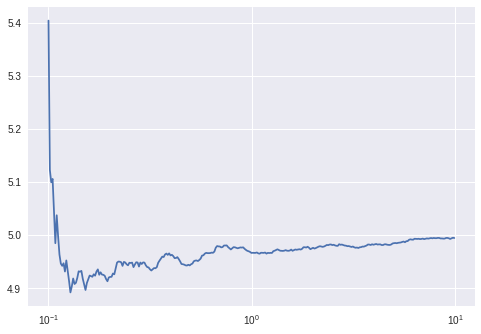

In [126]:
lr_find.plot_lr()